In [45]:
#add parent directory to sys.path to allow module imports
#see https://stackoverflow.com/questions/714063/importing-modules-from-parent-folder/11158224#11158224
import sys
sys.path.insert(1,'..')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import os
import glob
import ternary
import helpers.fileload as fl
#from helpers.calc_chemfeat import perovskite, formula_redfeat, formula_pif
from helpers.plotting import quat_slice_scatter, add_colorbar
from citrination_client import CitrinationClient
import pymatgen as mg
import pypif.pif

In [2]:
tcodir = os.path.join(os.environ['HOME'],'OneDrive - Colorado School of Mines/Research/MIDDMI/TCO')
datadir = os.path.join(tcodir,'data/eis') 
#pifdir = os.path.join(datadir,'pifs')
plotdir = os.path.join(tcodir,'scripts/eis/plots')

def sampledir(sample,src):
    return os.path.join(datadir,src,sample)

## ASR

In [100]:
data = pd.DataFrame()

src = 'in'
samples = next(os.walk(os.path.join(datadir,src)))[1]
for sample in samples:
    df = fl.load_sample_files(sampledir(sample,src),info_filter={'T_set':['500C'],'atm':['dry','wet']})
    fl.get_formula(df,overwrite=True)
    df['sample'] = sample
    df.index = df.index + sample
    data = data.append(df,sort=True)
data = data.loc[data['ASR'] > 0,:]
#get el amts after formula normalization
#note that if B-site is ever deficient, this will cause scale issues
Bsite = ['Co','Fe','Zr','Y'] #for B-site normalization
for idx in data.index:
    formula = data.loc[idx,'formula']
    cd = mg.Composition(formula).get_el_amt_dict()
    Bsum = np.sum([v for (k,v) in cd.items() if k in Bsite])
    for k,v in cd.items():
        #normalize to B-site
        data.loc[idx,k] = v/Bsum

#set nans to zero for Bsite
data.loc[:,Bsite] = data.loc[:,Bsite].fillna(0)

data['log_ASR'] = np.log10(data['ASR'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000248732E65F8>]],
      dtype=object)

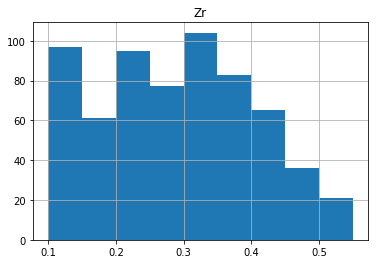

In [50]:
data.hist('Zr',bins=np.arange(0.1,0.6,0.05))

(3.470808730148019, 8.829785655905795)

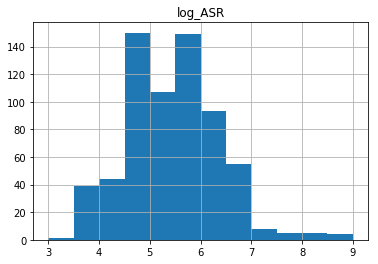

In [12]:
data.hist('log_ASR',bins=np.arange(3,9.5,0.5))
data['log_ASR'].min(),data['log_ASR'].max()

0.965
0.895
0.825


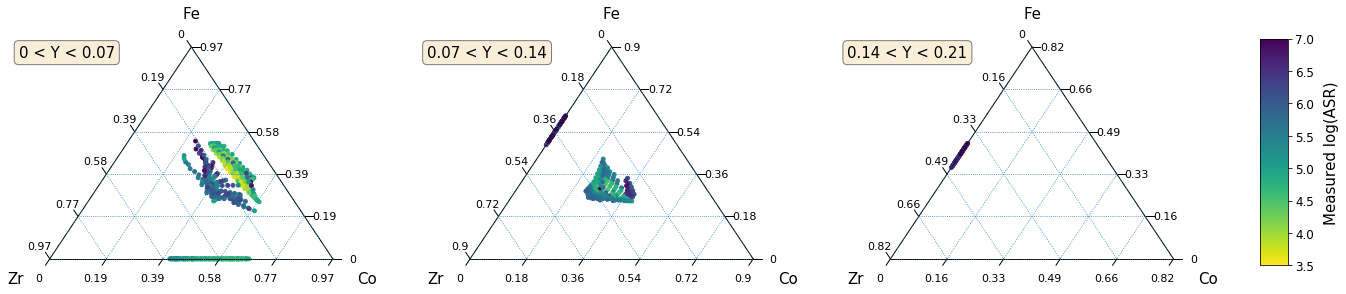

In [15]:
vmin = 3.5
vmax = 7
fig, axes = plt.subplots(1,3,figsize=(20,4.5))
slice_starts = [0, 0.07, 0.14]
slice_width = 0.07
slice_axis='Y'
cmap = plt.cm.viridis_r
for i,slice_start in enumerate(slice_starts):
    ax = axes[i]
    
    quat_slice_scatter(data,z='log_ASR',slice_start=slice_start,slice_width=slice_width,slice_axis=slice_axis,
                       tern_axes=['Co','Fe','Zr'], add_labeloffset=0.05,labelsize=15,
                       vmin=vmin,vmax=vmax,ax=ax,ptsize=15, nticks=5, cmap=cmap,
                       tick_kwargs={'axis':'lbr', 'linewidth':1, 'tick_formats':'%.2g','offset':0.03,'fontsize':11})
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.set_title('{:.2g} < {} < {:.2g}'.format(slice_start,slice_axis,slice_start+slice_width),
                 size=15,x=0.1,y=0.9,bbox=props)

add_colorbar(vmin=vmin,vmax=vmax,label='Measured log(ASR)',labelkwargs={'size':15,'labelpad':10}, cmap=cmap,
             tickparams={'labelsize':12}, tickformat='%.1f',ax=axes, cbrect=[0.9,0.18,0.02,0.7],
                subplots_adjust={'left':0.05,'wspace':0.35, 'hspace':0.25, 'right':0.85})
plt.savefig(os.path.join(plotdir,'exp_ASR_sliceY.png'),dpi=500)

0.845
0.6950000000000001
0.5449999999999999


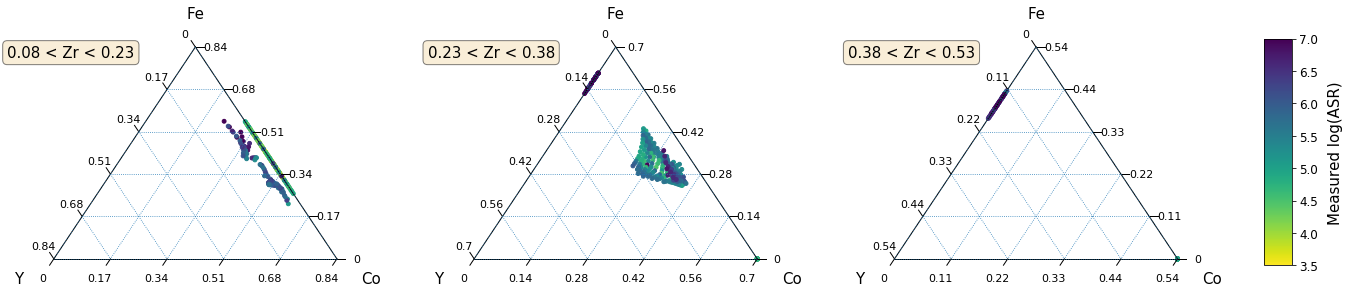

In [16]:
vmin = 3.5
vmax = 7
fig, axes = plt.subplots(1,3,figsize=(20,4.5))
slice_starts = [0.08, 0.23, 0.38]
slice_width = 0.15
slice_axis='Zr'
cmap = plt.cm.viridis_r
for i,slice_start in enumerate(slice_starts):
    ax = axes[i]
    
    quat_slice_scatter(data,z='log_ASR',slice_start=slice_start,slice_width=slice_width,slice_axis=slice_axis,
                       tern_axes=['Co','Fe','Y'], add_labeloffset=0.05,labelsize=15,
                       vmin=vmin,vmax=vmax,ax=ax,ptsize=15, nticks=5,cmap=cmap,
                       tick_kwargs={'axis':'lbr', 'linewidth':1, 'tick_formats':'%.2g','offset':0.03,'fontsize':11})
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.set_title('{:.2g} < {} < {:.2g}'.format(slice_start,slice_axis,slice_start+slice_width),
                 size=15,x=0.1,y=0.9,bbox=props)

add_colorbar(vmin=vmin,vmax=vmax,label='Measured log(ASR)',labelkwargs={'size':15,'labelpad':10}, cmap=cmap,
             tickparams={'labelsize':12}, tickformat='%.1f',ax=axes, cbrect=[0.9,0.18,0.02,0.7],
                subplots_adjust={'left':0.05,'wspace':0.35, 'hspace':0.25, 'right':0.85})
plt.savefig(os.path.join(plotdir,'exp_ASR_sliceZr.png'),dpi=500)

In [58]:
data['log_ASR'].min(),data['log_ASR'].max()

(3.470808730148019, 8.829785655905795)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000248748C98D0>]],
      dtype=object)

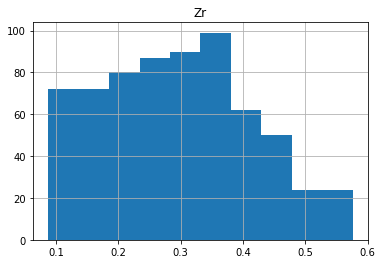

In [39]:
data.hist('Zr')

In [101]:
data[(data['T_set']=='500C')]

,ASR,Point,T_set,Temp_C,atm,formula,sample,x_mm,y_mm,Ba,Co,Fe,Y,Zr,O,log_ASR
1_500C_dryPDAC_COM3_01488,169614.590,1,500C,437,dry,Ba0.91162Co0.40788Fe0.30487Y0.05469Zr0.23256O3,PDAC_COM3_01488,0,0.00,0.911620,0.407880,0.304870,0.054690,0.232560,3.00000,5.229463
2_500C_dryPDAC_COM3_01488,214382.280,2,500C,437,dry,Ba0.90957Co0.37871Fe0.32098Y0.05549Zr0.24483O3,PDAC_COM3_01488,-4,0.00,0.909561,0.378706,0.320977,0.055489,0.244828,2.99997,5.331189
3_500C_dryPDAC_COM3_01488,569445.060,3,500C,437,dry,Ba0.91972Co0.35613Fe0.33813Y0.05609Zr0.24964O3,PDAC_COM3_01488,-8,0.00,0.919729,0.356134,0.338133,0.056091,0.249642,3.00003,5.755452
4_500C_dryPDAC_COM3_01488,588483.120,4,500C,437,dry,Ba0.91238Co0.33097Fe0.35299Y0.06109Zr0.25495O3,PDAC_COM3_01488,-12,0.00,0.912380,0.330970,0.352990,0.061090,0.254950,3.00000,5.769734
5_500C_dryPDAC_COM3_01488,551569.440,5,500C,437,dry,Ba0.91634Co0.30742Fe0.37091Y0.06435Zr0.25732O3,PDAC_COM3_01488,-16,0.00,0.916340,0.307420,0.370910,0.064350,0.257320,3.00000,5.741600
6_500C_dryPDAC_COM3_01488,455153.940,6,500C,437,dry,Ba0.91319Co0.28463Fe0.38397Y0.06837Zr0.26303O3,PDAC_COM3_01488,-20,0.00,0.913190,0.284630,0.383970,0.068370,0.263030,3.00000,5.658158
7_500C_dryPDAC_COM3_01488,347146.000,7,500C,437,dry,Ba0.913Co0.26403Fe0.39733Y0.06677Zr0.27187O3,PDAC_COM3_01488,-24,0.00,0.913000,0.264030,0.397330,0.066770,0.271870,3.00000,5.540512
8_500C_dryPDAC_COM3_01488,262687.410,8,500C,437,dry,Ba0.91131Co0.24899Fe0.41548Y0.06743Zr0.2681O3,PDAC_COM3_01488,-28,0.00,0.911310,0.248990,0.415480,0.067430,0.268100,3.00000,5.419439
9_500C_dryPDAC_COM3_01488,449593.310,9,500C,437,dry,Ba0.91218Co0.23455Fe0.42603Y0.06736Zr0.27207O3,PDAC_COM3_01488,-32,0.00,0.912171,0.234548,0.426026,0.067359,0.272067,2.99997,5.652820
10_500C_dryPDAC_COM3_01488,76736.539,10,500C,437,dry,Ba0.90631Co0.22283Fe0.44083Y0.06628Zr0.27006O3,PDAC_COM3_01488,-36,0.00,0.906310,0.222830,0.440830,0.066280,0.270060,3.00000,4.885002


## E_a

In [19]:
#load from pifs to avoid recalculating E_a from fits
pifdir = os.path.join(datadir,'pifs')

srcdir = os.path.join(pifdir,'ASR_Ea_Co(2,3)Fe(3,4)')
pifs = []
for file in glob.glob(os.path.join(srcdir,'*.json')):
    with open(file,'r') as f:
        fp = pypif.pif.load(f)
        pifs += fp

In [74]:
def conditionalprop_frompifs(pifs,conditionalprop,scalarprops=[]):
    """
    load conditional property from list of pifs. Each pif gets 1 row for each set of conditions
    ----------------------
    pifs: list of pifs
    conditionalprop: name of conditional property to load
    scalarprops: additional properties to load into dataframe. must be single-valued (non-conditional)
    """
    df = pd.DataFrame()
    for pif in pifs:
        pifdf = pd.DataFrame()
        pifdict = pif.as_dictionary()
        
        #conditional property - must be first since may have multiple values/conditions
        cproplist = [p for p in pifdict['properties'] if p['name']==conditionalprop]
        if len(cproplist) == 0:
            raise Exception('No property {}'.format(conditionalprop))
        elif len(cproplist) > 1:
            raise Exception('Multiple properties with name {}'.format(conditionalprop))
        else:
            propdict = cproplist[0]

        pifdf[conditionalprop] = propdict['scalars']
        for cond in propdict['conditions']:
            pifdf[cond['name']] = cond['scalars']
        
        #scalar props
        sprops = [p for p in pifdict['properties'] if p['name'] in scalarprops]
        for sp in sprops:
            pifdf[sp['name']] = sp['scalars']
        
        #ids and formula
        for pid in pifdict['ids']:
            pifdf[pid['name']] = pid['value']
        pifdf['formula'] = pif.chemical_formula
        
        df = df.append(pifdf)
        
    return df

In [72]:
cdf = conditionalprop_frompifs(pifs,'$E_a$',scalarprops=['Ba_amt','Co_amt','Fe_amt','Y_amt','Zr_amt'])
rename = {col:col[:-4] for col in cdf.columns if col[-4:]=='_amt'}
rename['$E_a$'] = 'E_a'
cdf.rename(columns=rename,inplace=True)

0.965
0.895
0.825
---------
Dry
---------


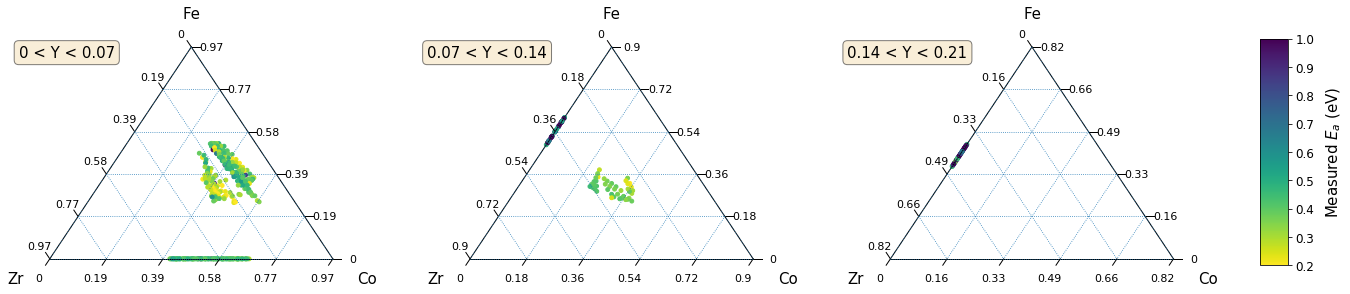

In [109]:
vmin = 0.2
vmax = 1
atm = 'dry'
fig, axes = plt.subplots(1,3,figsize=(20,4.5))
slice_starts = [0, 0.07, 0.14]
slice_width = 0.07
slice_axis='Y'
cmap = plt.cm.viridis_r
for i,slice_start in enumerate(slice_starts):
    ax = axes[i]
    tdf = cdf.loc[cdf['Atmosphere']==atm,:]
    
    quat_slice_scatter(tdf,z='E_a',slice_start=slice_start,slice_width=slice_width,slice_axis=slice_axis,
                       tern_axes=['Co','Fe','Zr'], add_labeloffset=0.05,labelsize=15,
                       vmin=vmin,vmax=vmax,ax=ax,ptsize=15, nticks=5, cmap=cmap,
                       tick_kwargs={'axis':'lbr', 'linewidth':1, 'tick_formats':'%.2g','offset':0.03,'fontsize':11})
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.set_title('{:.2g} < {} < {:.2g}'.format(slice_start,slice_axis,slice_start+slice_width),
                 size=15,x=0.1,y=0.9,bbox=props)

add_colorbar(vmin=vmin,vmax=vmax,label='Measured $E_a$ (eV)',labelkwargs={'size':15,'labelpad':10}, cmap=cmap,
             tickparams={'labelsize':12}, tickformat='%.1f',ax=axes, cbrect=[0.9,0.18,0.02,0.7],
                subplots_adjust={'left':0.05,'wspace':0.35, 'hspace':0.25, 'right':0.85})
plt.savefig(os.path.join(plotdir,'exp_dry_Ea_sliceY.png'),dpi=500)
print('---------\nDry\n---------')

0.965
0.895
0.825
---------
Wet
---------


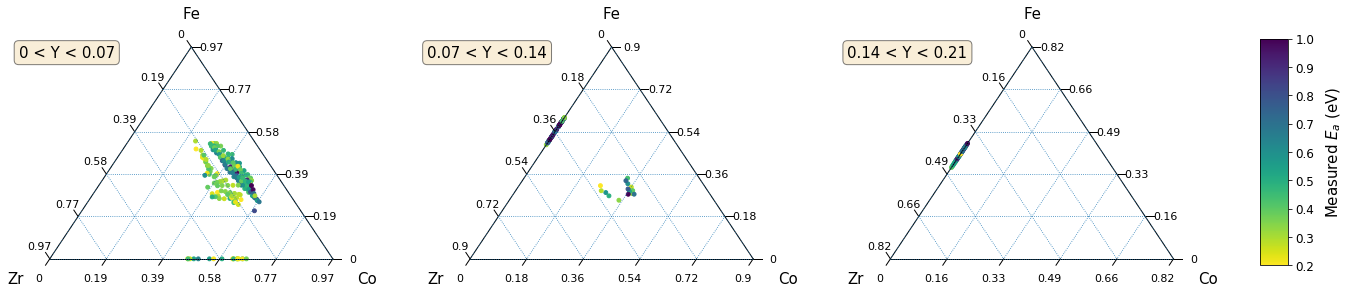

In [110]:
vmin = 0.2
vmax = 1
atm = 'wet'
fig, axes = plt.subplots(1,3,figsize=(20,4.5))
slice_starts = [0, 0.07, 0.14]
slice_width = 0.07
slice_axis='Y'
cmap = plt.cm.viridis_r
for i,slice_start in enumerate(slice_starts):
    ax = axes[i]
    tdf = cdf.loc[cdf['Atmosphere']==atm,:]
    
    quat_slice_scatter(tdf,z='E_a',slice_start=slice_start,slice_width=slice_width,slice_axis=slice_axis,
                       tern_axes=['Co','Fe','Zr'], add_labeloffset=0.05,labelsize=15,
                       vmin=vmin,vmax=vmax,ax=ax,ptsize=15, nticks=5, cmap=cmap,
                       tick_kwargs={'axis':'lbr', 'linewidth':1, 'tick_formats':'%.2g','offset':0.03,'fontsize':11})
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.set_title('{:.2g} < {} < {:.2g}'.format(slice_start,slice_axis,slice_start+slice_width),
                 size=15,x=0.1,y=0.9,bbox=props)

add_colorbar(vmin=vmin,vmax=vmax,label='Measured $E_a$ (eV)',labelkwargs={'size':15,'labelpad':10}, cmap=cmap,
             tickparams={'labelsize':12}, tickformat='%.1f',ax=axes, cbrect=[0.9,0.18,0.02,0.7],
                subplots_adjust={'left':0.05,'wspace':0.35, 'hspace':0.25, 'right':0.85})
plt.savefig(os.path.join(plotdir,'exp_wet_Ea_sliceY.png'),dpi=500)
print('---------\nWet\n---------')

0.845
0.6950000000000001
0.5449999999999999
---------
Dry
---------


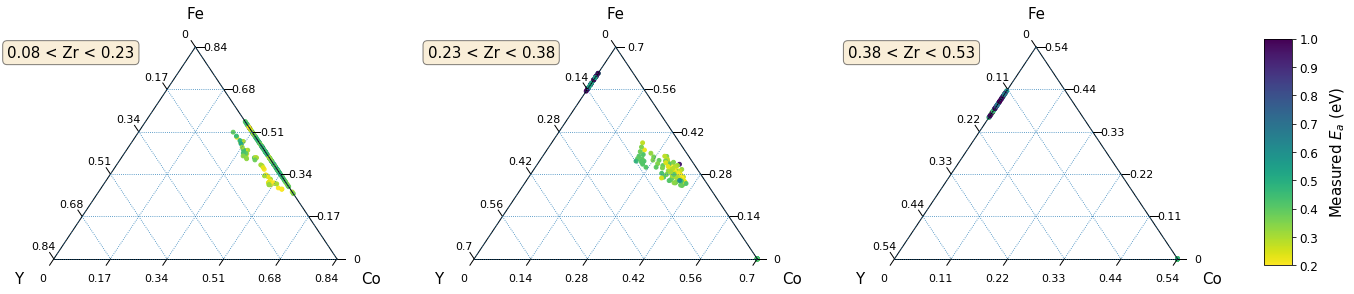

In [111]:
vmin = 0.2
vmax = 1
atm = 'dry'
fig, axes = plt.subplots(1,3,figsize=(20,4.5))
slice_starts = [0.08, 0.23, 0.38]
slice_width = 0.15
slice_axis='Zr'
cmap = plt.cm.viridis_r
for i,slice_start in enumerate(slice_starts):
    ax = axes[i]
    tdf = cdf.loc[cdf['Atmosphere']==atm,:]
    
    quat_slice_scatter(tdf,z='E_a',slice_start=slice_start,slice_width=slice_width,slice_axis=slice_axis,
                       tern_axes=['Co','Fe','Y'], add_labeloffset=0.05,labelsize=15,
                       vmin=vmin,vmax=vmax,ax=ax,ptsize=15, nticks=5, cmap=cmap,
                       tick_kwargs={'axis':'lbr', 'linewidth':1, 'tick_formats':'%.2g','offset':0.03,'fontsize':11})
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.set_title('{:.2g} < {} < {:.2g}'.format(slice_start,slice_axis,slice_start+slice_width),
                 size=15,x=0.1,y=0.9,bbox=props)

add_colorbar(vmin=vmin,vmax=vmax,label='Measured $E_a$ (eV)',labelkwargs={'size':15,'labelpad':10}, cmap=cmap,
             tickparams={'labelsize':12}, tickformat='%.1f',ax=axes, cbrect=[0.9,0.18,0.02,0.7],
                subplots_adjust={'left':0.05,'wspace':0.35, 'hspace':0.25, 'right':0.85})
plt.savefig(os.path.join(plotdir,'exp_dry_Ea_sliceZr.png'),dpi=500)
print('---------\nDry\n---------')

0.845
0.6950000000000001
0.5449999999999999
---------
Wet
---------


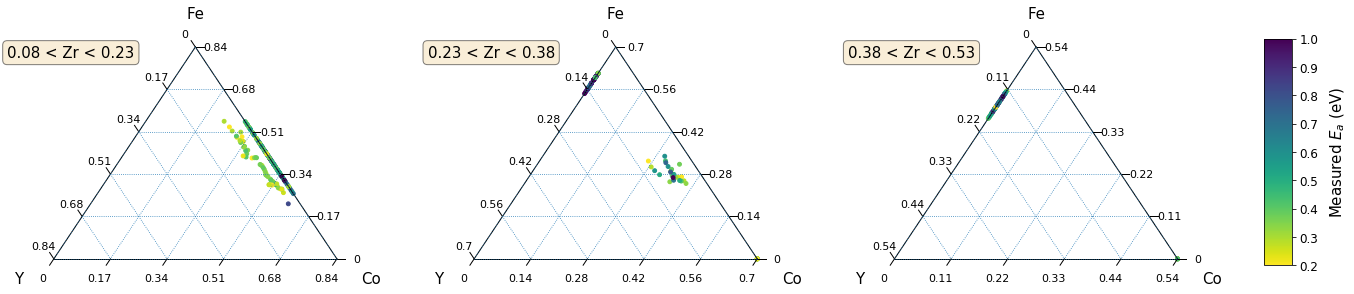

In [112]:
vmin = 0.2
vmax = 1
atm = 'wet'
fig, axes = plt.subplots(1,3,figsize=(20,4.5))
slice_starts = [0.08, 0.23, 0.38]
slice_width = 0.15
slice_axis='Zr'
cmap = plt.cm.viridis_r
for i,slice_start in enumerate(slice_starts):
    ax = axes[i]
    tdf = cdf.loc[cdf['Atmosphere']==atm,:]
    
    quat_slice_scatter(tdf,z='E_a',slice_start=slice_start,slice_width=slice_width,slice_axis=slice_axis,
                       tern_axes=['Co','Fe','Y'], add_labeloffset=0.05,labelsize=15,
                       vmin=vmin,vmax=vmax,ax=ax,ptsize=15, nticks=5, cmap=cmap,
                       tick_kwargs={'axis':'lbr', 'linewidth':1, 'tick_formats':'%.2g','offset':0.03,'fontsize':11})
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    ax.set_title('{:.2g} < {} < {:.2g}'.format(slice_start,slice_axis,slice_start+slice_width),
                 size=15,x=0.1,y=0.9,bbox=props)

add_colorbar(vmin=vmin,vmax=vmax,label='Measured $E_a$ (eV)',labelkwargs={'size':15,'labelpad':10}, cmap=cmap,
             tickparams={'labelsize':12}, tickformat='%.1f',ax=axes, cbrect=[0.9,0.18,0.02,0.7],
                subplots_adjust={'left':0.05,'wspace':0.35, 'hspace':0.25, 'right':0.85})
plt.savefig(os.path.join(plotdir,'exp_wet_Ea_sliceZr.png'),dpi=500)
print('---------\nWet\n---------')

In [90]:
tmp = cdf[(cdf['Y']<=0.025) & (cdf['Zr'] < 0.2)]
tw = tmp[tmp['Atmosphere']=='wet']
td = tmp[tmp['Atmosphere']=='dry']
#tmp['Atmosphere'].map({'dry':0,'wet':1}).hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001A94D1FB5C0>]],
      dtype=object)

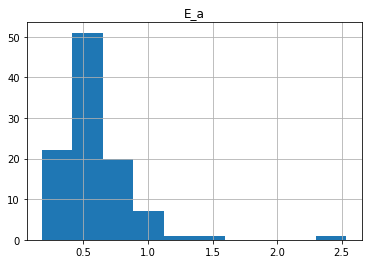

In [91]:
tw.hist('E_a')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001A94D314A20>]],
      dtype=object)

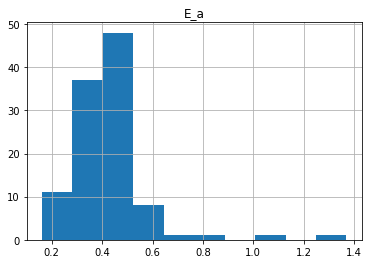

In [92]:
td.hist('E_a')